In [1]:
# Standard Libraries
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

# Third party Libraries
import earthpy as et
import geodatasets as gds
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import pandas as pd
import pyogrio
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

CLIMATE ZONE DATA DESCRIPTION HERE

CLIMATE ZONE CIATAION HERE

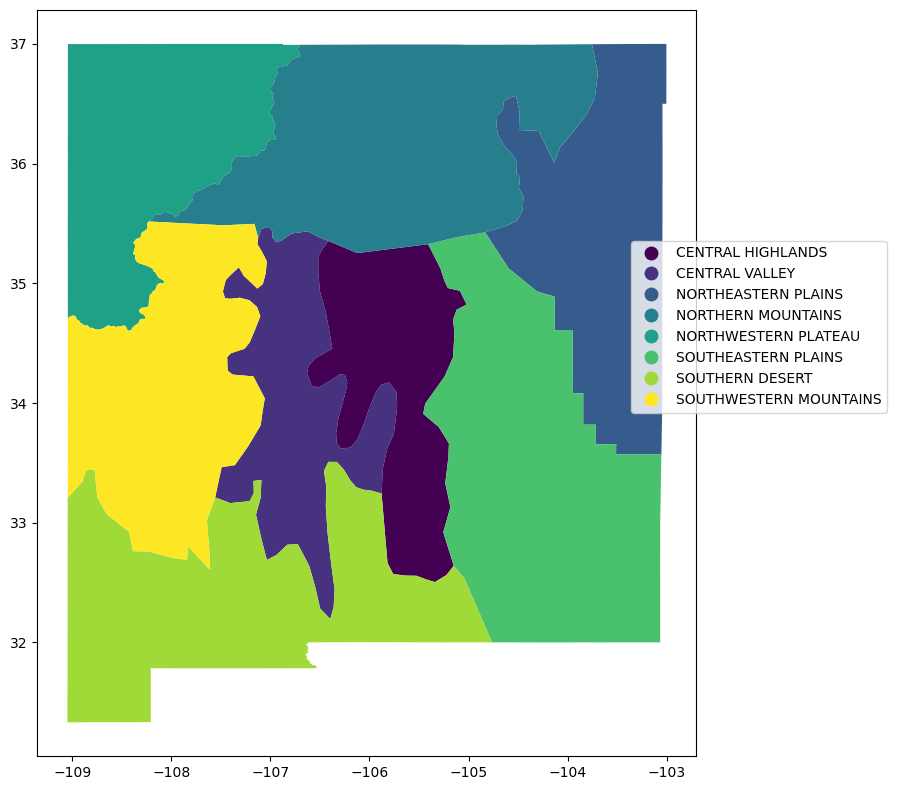

In [2]:
# Import climate zone shapefile and create geodataframe
climate_zone_url = ('https://www.ncei.noaa.gov/pub/data/cirs/climdiv/'
                    'CONUS_CLIMATE_DIVISIONS.shp.zip')
CONUS_climate_dl_path = et.data.get_data(url = climate_zone_url)

US_climate_zone_gdf = gpd.read_file(CONUS_climate_dl_path)

# Create new gdf w/ only NM climates and trim columns
NM_climates_gdf = US_climate_zone_gdf[US_climate_zone_gdf['STATE'] == 'New Mexico']

NM_climates_gdf = (
    NM_climates_gdf[['STATE', 'NAME', 'geometry']]
    .set_index('STATE')
    .to_crs(4326))

ax = NM_climates_gdf.plot(column = 'NAME', cmap = 'viridis', legend= True)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(10, 8)

# Move the legend to the right side
ax.legend_.set_bbox_to_anchor((1.3,0.7))
plt.tight_layout()

In [3]:
wildfire_url = ('https://www.fs.usda.gov/rds/archive/products/'
                'RDS-2013-0009.6/RDS-2013-0009.6_Data_Format2_GDB.zip')
wildfire_dir = et.data.get_data(url = wildfire_url)

fire_path = os.path.join(wildfire_dir, 
                         'Data', 
                         'FPA_FOD_20221014.gdb')
if not 'fire_gdf' in globals():
    print('fire_gdf does not exist. Loading....')
    fire_gdf = pyogrio.read_dataframe(fire_path, layer='Fires')

NM_fires_gdf = fire_gdf[fire_gdf['STATE'] == 'NM']

# Create new dataframe with relevant columns only
NM_fire_size_gdf = (
    NM_fires_gdf[['FOD_ID', 'DISCOVERY_DATE', 'FIRE_SIZE', 'geometry']]
              .set_index('FOD_ID'))

# Set Discovery Date value to datetime64
NM_fire_size_gdf.DISCOVERY_DATE = pd.to_datetime(NM_fire_size_gdf.DISCOVERY_DATE)
# Set crs of geodataframe to same as watershed gdf
NM_fire_size_gdf = NM_fire_size_gdf.to_crs(NM_climates_gdf.crs)

NM_fire_size_gdf

fire_gdf does not exist. Loading....


,DISCOVERY_DATE,FIRE_SIZE,geometry
FOD_ID,,,
20,2004-06-04,0.10,POINT (-105.72055 33.44083)
21,2004-06-19,0.10,POINT (-105.62860 33.30721)
22,2004-06-21,0.10,POINT (-105.76805 33.44444)
23,2004-06-25,0.10,POINT (-105.76610 33.55944)
24,2004-07-01,0.25,POINT (-105.52610 33.30805)
...,...,...,...
400635292,2020-05-25,1.00,POINT (-108.41930 32.62520)
400635295,2020-07-14,0.10,POINT (-108.90240 31.73078)
400635299,2020-06-15,293.00,POINT (-109.00640 31.75032)


In [5]:
NM_fire_region_gdf = (
    NM_climates_gdf
    [['NAME', 'geometry']]
    .sjoin(NM_fire_size_gdf, how = 'inner', predicate = "intersects")
)
NM_fire_region_gdf = (
    NM_fire_region_gdf
    .groupby(['NAME', NM_fire_region_gdf.DISCOVERY_DATE.dt.year])
    .agg(
        max_fire_size=('FIRE_SIZE', 'max'),
        num_fires=('index_right', 'count')
    )
)

NM_fire_region_gdf

max_fire_size  num_fires
NAME                   DISCOVERY_DATE                          
CENTRAL HIGHLANDS      1992                     26.0        105
                       1993                   5350.0        208
                       1994                  10000.0        338
                       1995                   1600.0        209
                       1996                   8260.0        295
...                                              ...        ...
SOUTHWESTERN MOUNTAINS 2016                  42102.0        202
                       2017                  20501.0        115
                       2018                  50296.0        181
                       2019                   5162.0        130
                       2020                  25950.0        144

[232 rows x 2 columns]

In [7]:
# Reproject watershed DF to Albers EA and report area in millions of 
# hectares w/ geometry
NM_climates_gdf['area_ha'] = (
    NM_climates_gdf.to_crs(9822).area 
    # Convert to hectares
    / 10000
    # Convert to millions of hectares
    /1000000
)

(
    NM_climates_gdf
    [['NAME', 'area_ha', 'geometry']]
)

# Reset index and display fire count per watershed
NM_fire_count_gdf = (
    NM_fire_region_gdf
    .reset_index()
    [['NAME', 'num_fires']]
    .groupby('NAME')
    .sum()
)

# Add area and geometry data back into dataframe
NM_fire_density_df= (
    NM_climates_gdf
    .set_index('NAME')
    .join(NM_fire_count_gdf)
    [['num_fires', 'area_ha', 'geometry']]
)

# Add column for fires per hectare
NM_fire_density_df['fire_density_per_ha'] = (
    NM_fire_density_df.num_fires / NM_fire_density_df.area_ha)

NM_fire_density_df

,num_fires,area_ha,geometry,fire_density_per_ha
NAME,,,,
CENTRAL VALLEY,3328,2.605538,"POLYGON ((-105.87800 33.24400, -105.98500 33.2...",1277.279227
CENTRAL HIGHLANDS,4978,2.617466,"POLYGON ((-105.14900 32.64000, -105.22300 32.5...",1901.839161
NORTHEASTERN PLAINS,2265,3.868647,"POLYGON ((-104.12943 34.77932, -104.13290 34.8...",585.475996
SOUTHEASTERN PLAINS,5067,5.584829,"POLYGON ((-104.76431 32.00053, -105.03800 32.5...",907.279298
NORTHWESTERN PLATEAU,7357,3.432855,"POLYGON ((-106.96946 37.00011, -106.95281 37.0...",2143.114318
NORTHERN MOUNTAINS,10709,4.970772,"POLYGON ((-104.89187 35.41759, -105.13100 35.3...",2154.393540
SOUTHERN DESERT,1585,4.912759,"POLYGON ((-105.87800 33.24400, -105.81800 32.6...",322.629319
SOUTHWESTERN MOUNTAINS,8247,4.050671,"POLYGON ((-109.04724 33.20878, -109.04712 33.2...",2035.959072


In [10]:
### Plot fire occurrence and size over time for each region


# Set values for ylabels and titles
labels = pd.DataFrame(dict(
    column_name = ['max_fire_size', 'num_fires'],
    ylabel = ['Fire Size (million ha)', 'Number of Fires'],
    title = ['Largest Fire on Record in Region', 
             'Total Number of Fires in Region']))

def fire_plot(region_name, df=NM_fire_region_gdf, labels=labels):
    """
    Create a multi-panel plot for a region

    Parameters
    ----------
    region_name : str
      The name of the region to generate a plot for. Must exists 
      in the 'name' index of df.
    df : pd.DataFrame
      The dataframe with the data to plot. Columns much match
      an item in labels.column_name to be plotted
    labels : pd.DataFrame
      Plot labels. Must have a 'column_name', 'ylabel', and 'title'
      columns with str values. Each row will be a subplot.

    Returns
    -------
    plot : hv.core.layout.Layout
      A holoviews plot layout or similar. For use with hv.DynamicMap.
    """
    # Generate a subplot for each row in the labels
    subplots = []
    # Iterate through the labels row by row
    for i, labs in labels.iterrows():
        # Create subplot
        subplot = (
            df.xs(region_name, level='NAME')
            [[labs.column_name]]
            .hvplot(
                xlabel = 'Year', ylabel = labs.ylabel, title = labs.title,
                width = 1000, color = 'orange', size = 2 
            ))
        subplots.append(subplot)
        

    # Stack the subplots vertically
    plot = hv.Layout(subplots).cols(1)
    return plot

# Create a dropdown menu to switch between regions
(
    hv.DynamicMap(
        # The plotting function for the two-panel fire history
        fire_plot,
        # Define the dimension for the dropdown
        kdims=[('region', 'Region')])
    # Add the explicit indexing - region names as a bokeh dimension
    .redim.values(region=NM_fire_region_gdf.reset_index().NAME)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ceffa298-956b-4400-bccf-6a91baa34900': {'version…